# AI4IA Hackathon Phase 1: présentation du DataSet et exemple.s de prédiction

# Description:

Ce Notebook est mis à disposition des candidats du Challenge AI4IA-1ere Edition et est exclusivement dédié à cet évènement.

Le but de cet exemple classique est d'aider à la compréhension de ce qui est attendu des candidats, d'introduire les outils mis à disposition ainsi que les jeux de données et leur format. 

Les éléments fournis sont les suivants:
- jeu de données d'exemple (./data/DataSet_ex) sous la forme de plusieurs fichiers .csv, chacun correspondant à un signal d'excitation ;
- fichiers de définition des modèles et de leurs interfaces (cf. model_api.py et les exemples my_model1.py / my_model2.py). Note: le fichier de définition des modèles est la principale soumission des candidats: c'est à ce niveau qu'il est demandé d'implémenter l'architecture du modèle, ainsi que les stratégies d'inférence et d'entrainement;
- script générique pour le lancement d'un entraînement sur une instance AWS via sagemaker ou en local (sagemajer_api.py);
- scripts génériques pour l'évaluation des performances du modèle sur une instance AWS via sagemaker ou en local telles que définies pas les évaluateurs (les mêmes critères d'évaluation/métriques seront appliquées durant la phase d'évalutation, en considérant un jeu de données identique pour chaque candidat ainsi qu'une machine/instance AWS identique);
- une classe de test unitaire (cf. test_submission.py) permettant à tout instant de tester si la solution développée (la définition du modèle notamment) est conforme à ce qui est attendu et à ce qui sera mis en oeuvre lors de la phase d'évaluation. 

Note: il est donc indispensable que le modèle soumis par l'équipe candidate valide tous les tests unitaires et présente les caractéristiques nécessaires à l'évaluation de ses performances sur des instances AWS avec un fichier de test csv arbitraire (via calc_metrics_on_sagemaker.py). Il est donc vivement recommandé de s'assurer que le modèle développé présente bien ces caractéristiques.

Author: François Caire \
Maintainer: François Caire \
Email: francois.caire at skf.com 

# Sommaire :
1. [Chargement des Modules](#1-bullet)
2. [Chargement et exploration du DataSet](#2-bullet)
3. [Exemple Rudimentaire d'apprentissage](#3-bullet)
4. [Entraînement sur AWS SageMaker](#4-bullet)
5. [Evaluation de la solution en local et AWS SageMaker](#5-bullet)

# 1. Chargement des Modules <a class="anchor" id="1-bullet"></a>

Ici on importe les modules classiques

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

On ajoute des paramètres d'affichage et de tracé...

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2.0

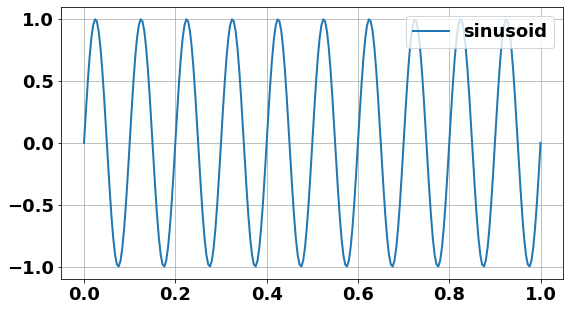

In [3]:
t=np.linspace(0,1,251)
y=np.sin(t*10*2*np.pi)

plt.figure(figsize=(9,5))
plt.plot(t,y,label='sinusoid')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# 2. Chargement et Exploration/Tracé du DataSet d'exemple <a class="anchor" id="2-bullet"></a>

In [4]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(7)]

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)
    d[name] = d[name][["Time", "Input", "Output1", "Output2", "Output3", "Output4", "Output5"]]

In [5]:
d['input1'].head()

,Time,Input,Output1,Output2,Output3,Output4,Output5
0,0.000,0.0,-2.464122e-07,0.5,0.5,1.011923,1.00983
1,0.001,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
2,0.002,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
3,0.003,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
4,0.004,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983


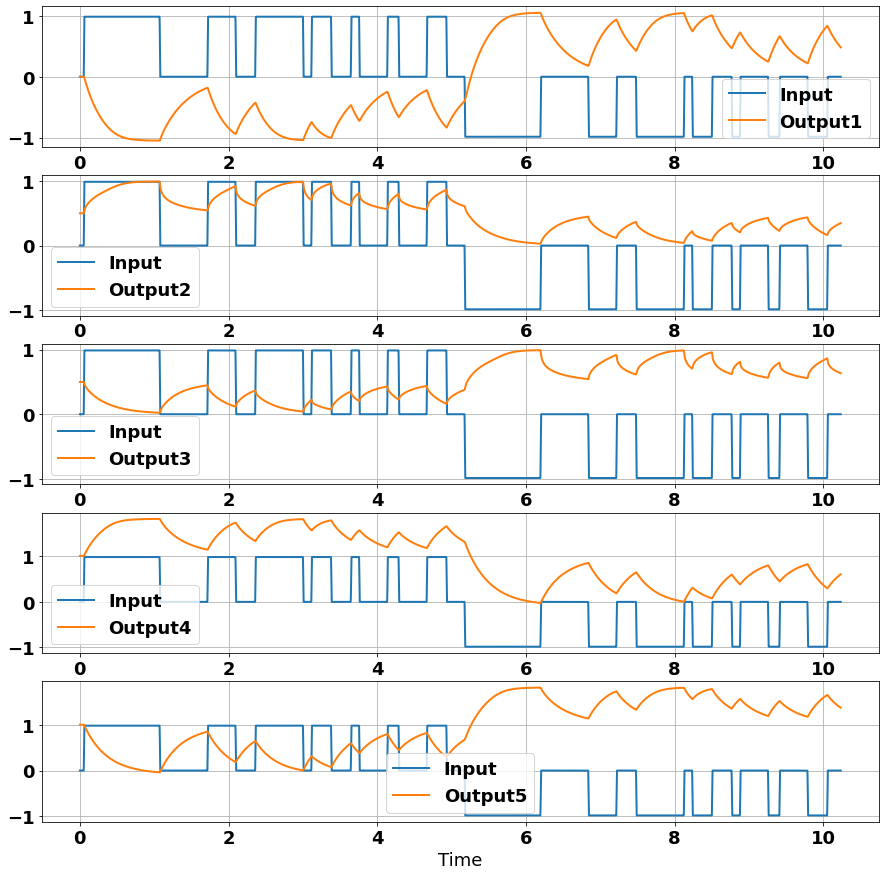

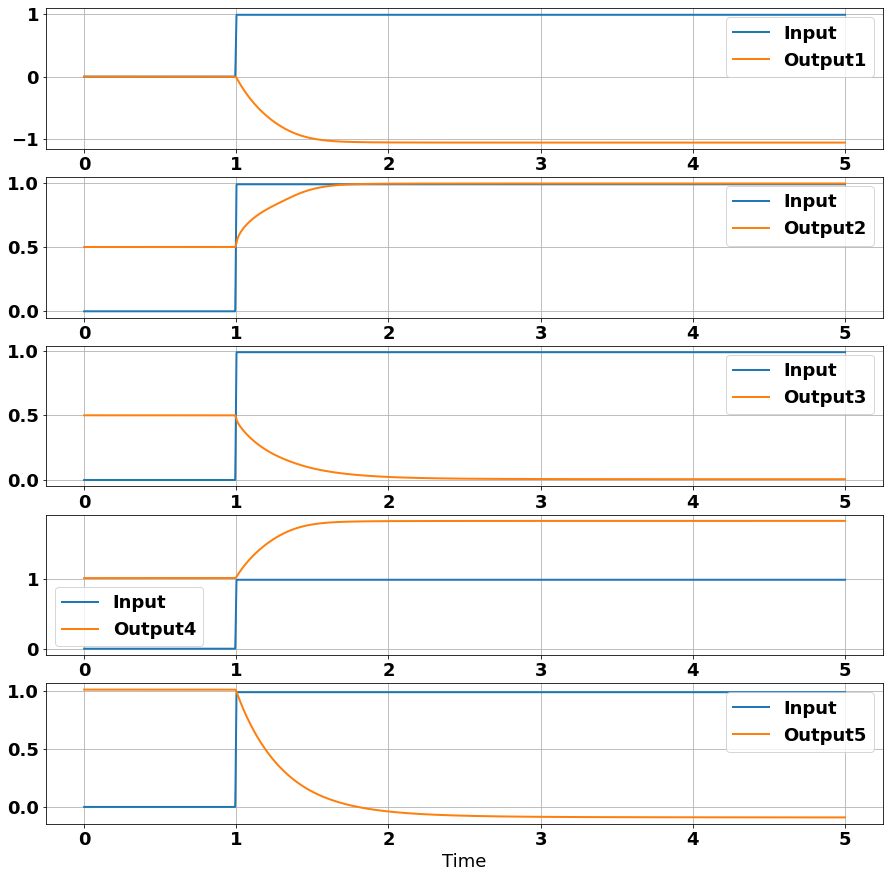

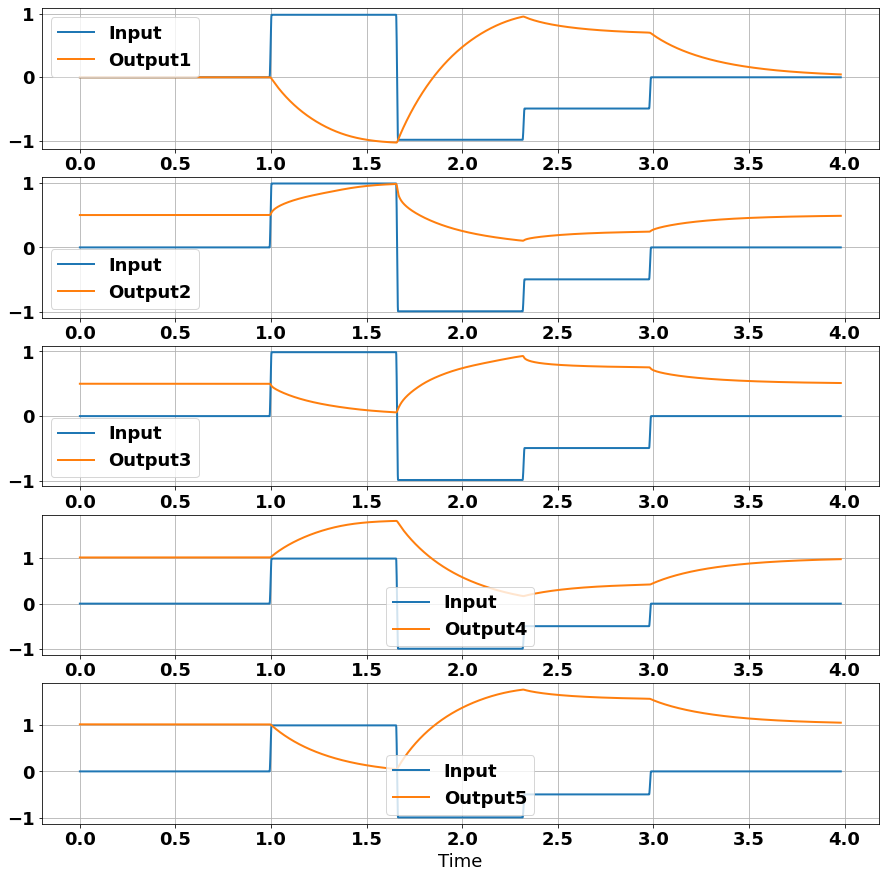

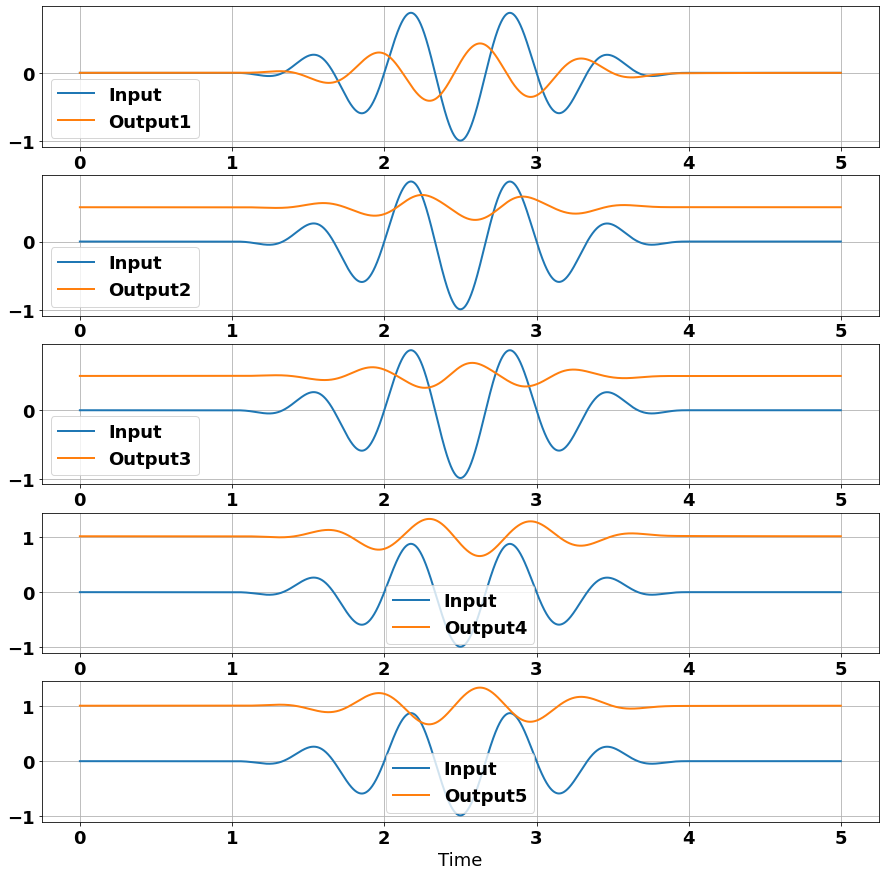

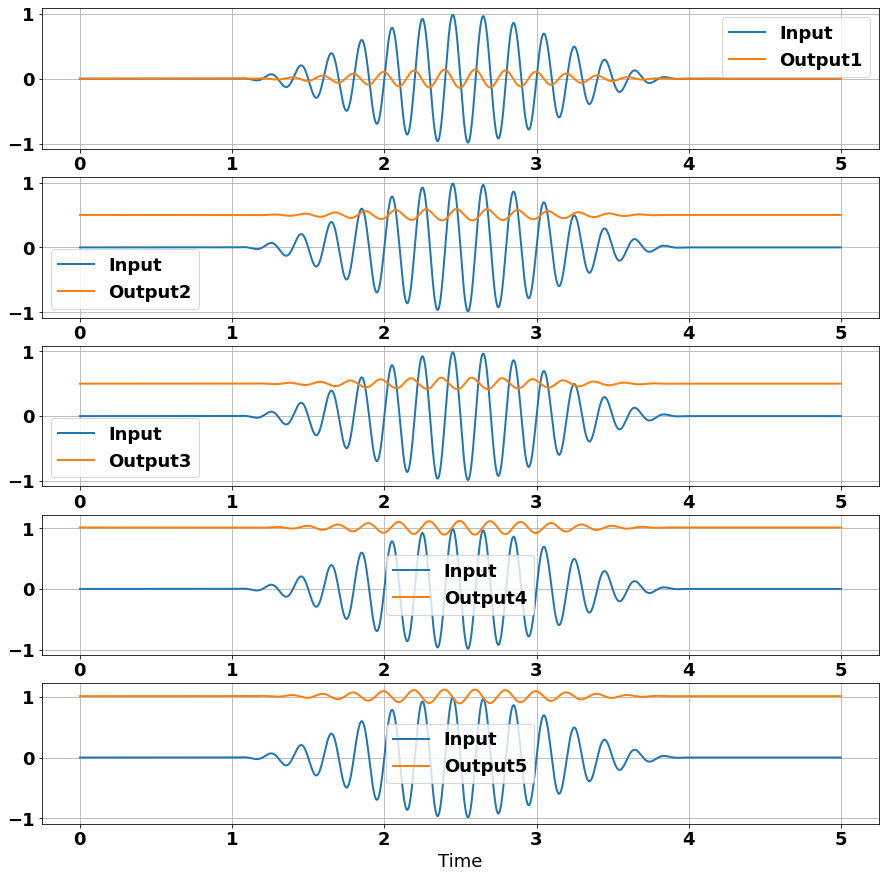

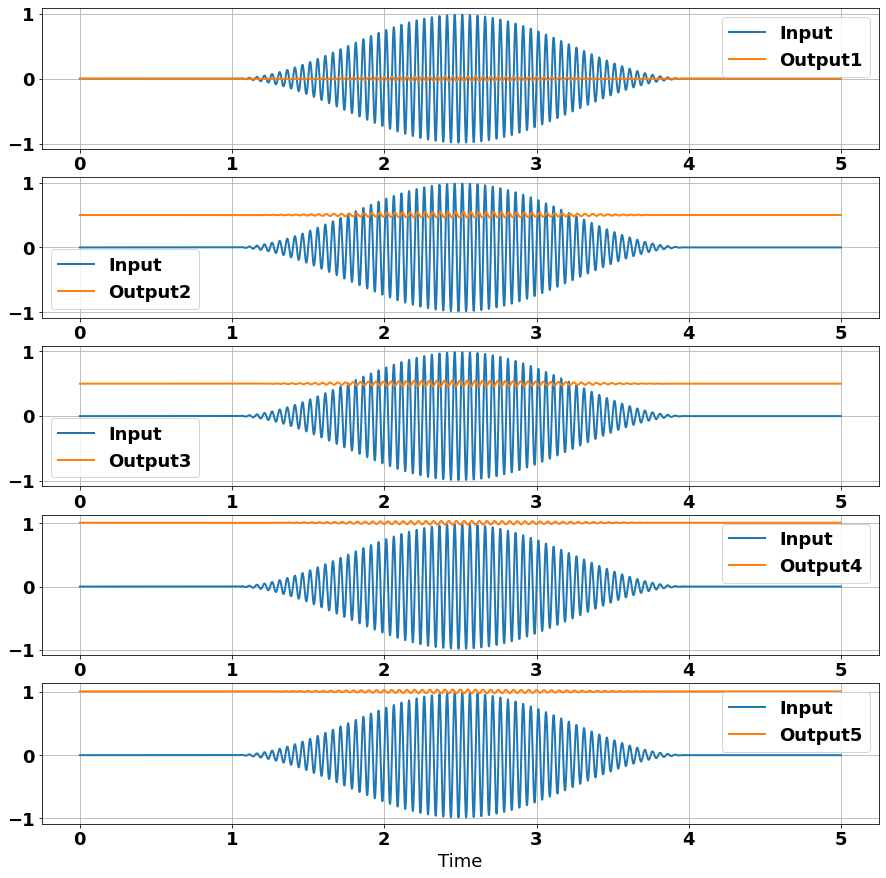

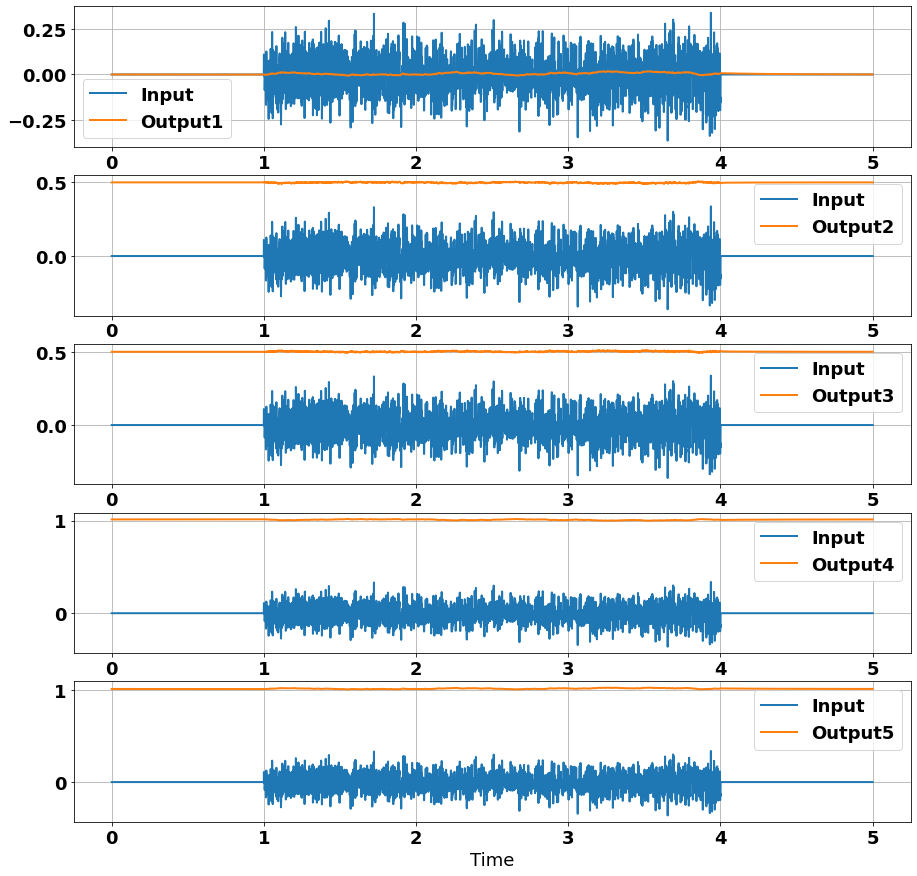

In [6]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

In [7]:
from sources.utilities.utility_functions import *

t,x,y = load_data_csv("data/DataSet_phase1/input0.csv", name_input="Input", names_outputs = ["Output"+str(k) for k in range(1,6)])

# 3. Exemple rudimentaire d'apprentissage <a class="anchor" id="3-bullet"></a>

0. Chargement des modules d'intérêt

In [86]:
import sys
from importlib import reload,import_module
import os

import sagemaker
import boto3

import tensorflow as tf

In [9]:
#sys.path.append('sources')
#sys.path.append(os.path.join('sources','utilities'))

1. On charge ici le modele créé specifiquement

In [10]:
model_definition = "keras_model"

MyModel = import_module('sources.utilities.' + model_definition).Keras_Model

On peut vérifier grâce aux tests unitaire que le modele est valide pour soumission (NB: il doit calculer cinq sorties pour les cinq grandeurs d'intérêt)

In [11]:
# !python sources/utilities/test_submission.py my_model1
# !python sources/utilities/test_submission.py my_model2

!python sources/utilities/test_submission.py keras_model

Epoch 1/50
Model Description : 
{'affiliation': 'Company/Instituition',
 'description': 'description of the model and architecture',
 'email': 'your_email@gmail.com',
 'model_title': 'Model title - e.g. My Favorite Model',
 'other_remarks': "put here anything else you'd like us to know",
 'team_name': 'team_name',
 'technology_stack': 'technology stack you are using, e.g. sklearn, pytorch'}


2021-10-26 10:23:44.395696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-10-26 10:23:44.395720: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-26 10:23:46.516399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-10-26 10:23:46.516423: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-26 10:23:46.523891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-5UJHVL18
2021-10-26 10:23:46.523948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-5UJHVL18
2021-10-26 10:23:46.526309: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is

2- l'objectif de ce challenge est de construire un modèle qui permette de calculer cinq signaux de sorties (les cinq outputs présentes dans les fichiers que nous vous avons transmis) et qui prenne en entrée un signal d'entrée (la série temporelle input contenue dans chaque fichier). La structure interne de ce modèle est libre. Également, les données d'entraînement peuvent être construites par les candidats : vous avez, par exemple, la possibilité de construire un nouveau fichier csv dédié à l'entraînement de votre modèle à partir d'un traitement de votre choix réalisé sur les données contenues dans les fichiers csv que nous vous avons transmis.

2. On selectionne le/les signaux utiles pour l'apprentissage et ceux pour la validation:

In [87]:
rep_data   = "data/DataSet_phase1/"
file_train = "input4.csv"
file_valid = "input5.csv"

t_train,x_train,y_train = load_data_csv(rep_data+file_train, name_input="Input", names_outputs = ["Output"+str(k) for k in range(1,6)])
x_train = x_train.reshape(x_train.shape[0], 1, 1)

t_valid,x_valid,y_valid = load_data_csv(rep_data+file_valid, name_input="Input", names_outputs = ["Output"+str(k) for k in range(1,6)])
x_valid = x_valid.reshape(x_valid.shape[0], 1, 1)

In [91]:
np.vstack(y_train)

array([[-2.46412166e-07, -2.46412130e-07, -2.46412130e-07, ...,
        -1.64224136e-05, -1.63795525e-05, -1.63368084e-05],
       [ 5.00000000e-01,  5.00000000e-01,  5.00000000e-01, ...,
         5.00005730e-01,  5.00005715e-01,  5.00005701e-01],
       [ 5.00000000e-01,  5.00000000e-01,  5.00000000e-01, ...,
         4.99997257e-01,  4.99997265e-01,  4.99997274e-01],
       [ 1.01192283e+00,  1.01192283e+00,  1.01192283e+00, ...,
         1.01194249e+00,  1.01194244e+00,  1.01194240e+00],
       [ 1.00982970e+00,  1.00982970e+00,  1.00982970e+00, ...,
         1.00982341e+00,  1.00982343e+00,  1.00982345e+00]])

In [92]:
train_data = tf.data.Dataset.from_tensor_slices((x_train,np.vstack(y_train))).batch(5).repeat()
valid_data = tf.data.Dataset.from_tensor_slices((x_valid,np.vstack(y_valid))).batch(5).repeat()

ValueError: Dimensions 5000 and 5 are not compatible

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm_34 (LSTM)                  (None, 1, 20)        1760        input_2[0][0]                    
__________________________________________________________________________________________________
lstm_35 (LSTM)                  (None, 1, 20)        1760        input_2[0][0]                    
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 1, 20)        1760        input_2[0][0]                    
____________________________________________________________________________________________

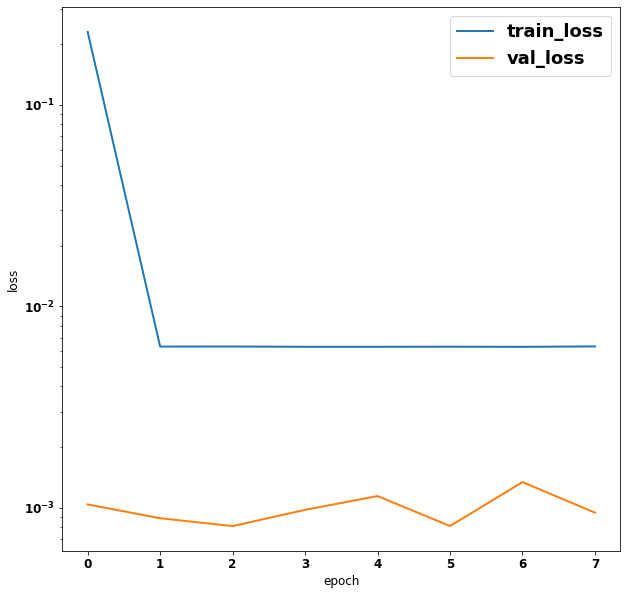

In [93]:
retrain = True

if retrain:
    Ndecim=5
    # outputs_indexes = [1, 2, 3, 4]
    model = MyModel.create_model()
    
    
#     history = model.fit(X_train=x_train[::Ndecim], y_train=[y_train[k][::Ndecim] for k in outputs_indexes],
#                         X_valid=x_valid[::Ndecim], y_valid=[y_valid[k][::Ndecim] for k in outputs_indexes])
    
    history = model.fit(X_train=x_train, y_train=y_train,X_valid=x_valid, y_valid=y_valid)
    
    plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
    plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.show()
    
    retrain = False

In [100]:
x_train[0].shape

(1, 1)

In [105]:
y_train[0].shape

(5000,)

In [104]:
y_pred_train[0].shape

(5000, 1, 1)

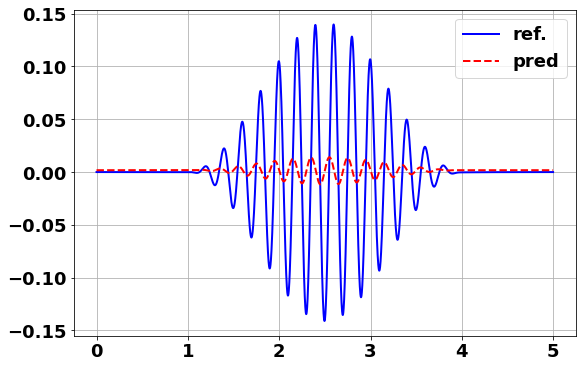

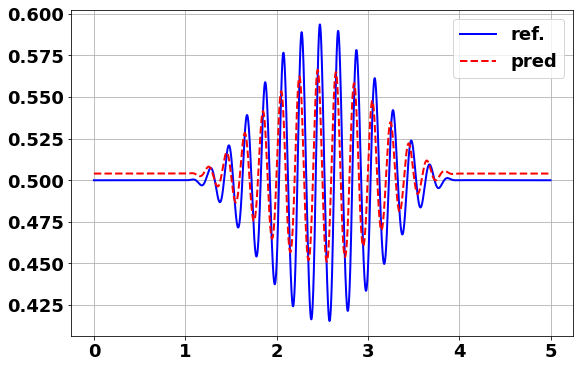

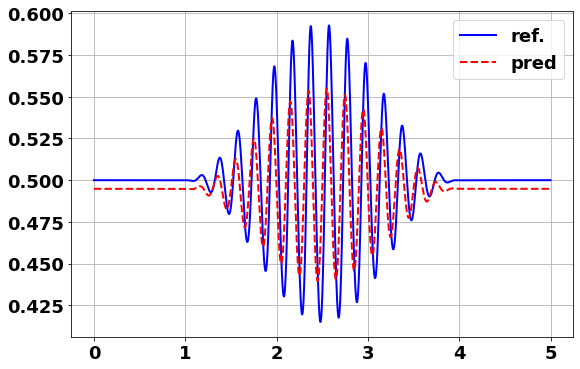

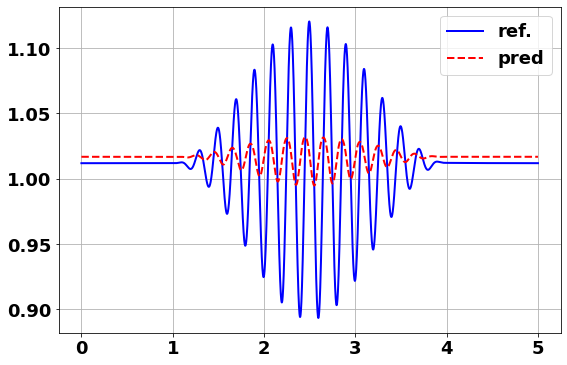

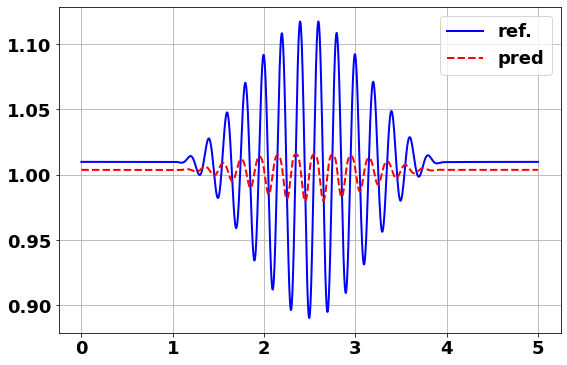

In [106]:
y_pred_train = model.predict_timeseries(x_train)
# y_pred_train = y_pred_train.reshape(y_pred_train.shape[0], y_pred_train.shape[2])
# print(y_pred_train.shape)
for k in range(5):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    y_pred_train[k] = y_pred_train[k].reshape(y_pred_train[k].shape[0])
    ax.plot(t_train,y_train[k],'b', t_train,y_pred_train[k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

In [57]:
y_pred_train.shape

(1000,)

In [ ]:
file_test  = "input1.csv"
t_test,x_test,y_test = load_data_csv(rep_data+file_test)

y_pred = model.predict_timeseries(x_test[::Ndecim])

for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_test[::Ndecim],y_test[outputs_indexes[k]][::Ndecim],'b',t_test[::Ndecim],y_pred[k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

# 4. Lancement sur AWS SageMaker <a class="anchor" id="4-bullet"></a>

0. Test local

Permet de vérifier que tout est ok avant de monter l'image sur une instance amazon (ce qui peut être long)

In [34]:
rep = "data/DataSet_ex/"
file_train = "input4.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName\
                              --model_def_file $model_definition 


Failed to load default container env keys. Using local default keys.
it. 0 / 40 - loss = 0.06930216
it. 1 / 40 - loss = 0.06497432
it. 2 / 40 - loss = 0.13109641
it. 3 / 40 - loss = 0.54755175
it. 4 / 40 - loss = 0.13990161
it. 5 / 40 - loss = 0.01997093
it. 6 / 40 - loss = 0.08145026
it. 7 / 40 - loss = 0.04227635
it. 8 / 40 - loss = 0.01723655
it. 9 / 40 - loss = 0.01093052
it. 10 / 40 - loss = 0.01410916
it. 11 / 40 - loss = 0.01285029
it. 12 / 40 - loss = 0.01321856
it. 13 / 40 - loss = 0.00711607
it. 14 / 40 - loss = 0.00395724
it. 15 / 40 - loss = 0.00368952
it. 16 / 40 - loss = 0.00360944
it. 17 / 40 - loss = 0.00351926
it. 18 / 40 - loss = 0.00320611
it. 19 / 40 - loss = 0.00276755
it. 20 / 40 - loss = 0.00249503
it. 21 / 40 - loss = 0.00235161
it. 22 / 40 - loss = 0.00226110
it. 23 / 40 - loss = 0.00218943
it. 24 / 40 - loss = 0.00212878
it. 25 / 40 - loss = 0.00206933
it. 26 / 40 - loss = 0.00200520
it. 27 / 40 - loss = 0.00194061
it. 28 / 40 - loss = 0.00188689
it. 29 / 40 -

<Figure size 432x288 with 0 Axes>

In [35]:
t_train,x_train,y_train = load_data_csv(rep+file_train,Ndecim=Ndecim)
file_test  = "input3.csv"

In [36]:
model = MyModel.load(model_dir)

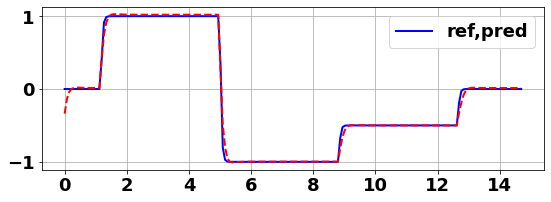

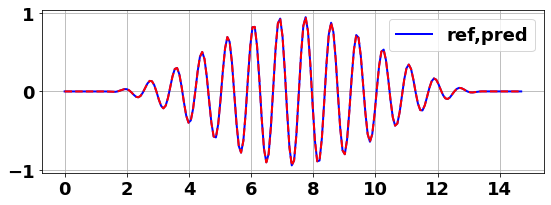

In [37]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[outputs_indexes[k]],'b',t_train,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[outputs_indexes[0]],'b',t_train,y_pred[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])
    
t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)

fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_test,y_test[outputs_indexes[k]],'b',t_test,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[outputs_indexes[0]],'b',t_test,y_test[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


1. Depôt des données sur S3

In [47]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix_in  = 'DEMO-AI4IA/input'
prefix_out = 'DEMO-AI4IA/model'
role = "<your-sagemaker-role>"

In [41]:
rep_data = './data/DataSet_ex/'

input_channel = sagemaker_session.upload_data(path=rep_data, bucket=bucket, key_prefix=prefix_in)
print('input file (in this case, just an S3 path): {}'.format(input_channel))


input file (in this case, just an S3 path): s3://sagemaker-eu-west-1-480368206057/DEMO-AI4IA/input


2. Creation des instances et paramétrage de l'estimateur:

In [42]:
output_path = f's3://'+bucket+'/'+prefix_out

outputs_indexes = [0,1,2]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])

In [44]:
model_name = 'model_GRU'
max_run = 60*60*6 # Max time in seconds

sagemaker_estimator,framework_version = model.get_sagemaker_estimator_class()
estimator = sagemaker_estimator(entry_point = 'sagemaker_api.py',
                                source_dir  = 'sources',
                                role = role,
                                py_version = 'py3',
                                max_run=max_run,
                                framework_version = framework_version,
                                instance_count = 1,
                                instance_type='ml.p3.2xlarge', #'ml.m4.xlarge',#'ml.p2.xlarge',#'ml.p3.2xlarge',#
                                output_path=f's3://'+bucket+'/'+prefix_out,
                                hyperparameters={
                                                    'use_gpu':True,
                                                    'epochs':350,
                                                    'lr':.05,
                                                    'outputs_indexes': outputs_ind,
                                                    'Ndecim':5,
                                                    'train_fileName':file_train,
                                                    'model_def_file':'my_model2'
                                }
                               )

In [45]:
estimator.fit({'training': input_channel})

2021-10-23 10:04:41 Starting - Starting the training job...
2021-10-23 10:05:04 Starting - Launching requested ML instancesProfilerReport-1634983480: InProgress
......
2021-10-23 10:06:09 Starting - Preparing the instances for training.........
2021-10-23 10:07:45 Downloading - Downloading input data
2021-10-23 10:07:45 Training - Downloading the training image...................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-23 10:10:52,566 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-23 10:10:52,591 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-23 10:10:54,039 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-23 10:10:54,462 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
       

In [49]:
training_job_name = estimator.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
trained_model_location = desc['ModelArtifacts']['S3ModelArtifacts']
display('Model is here: {}'.format(trained_model_location))



'Model is here: s3://sagemaker-eu-west-1-480368206057/DEMO-AI4IA/model/pytorch-training-2021-10-23-10-04-40-602/output/model.tar.gz'

In [78]:
prefix_out+desc['TrainingJobName']+'/output/model.tar.gz'

'DEMO-AI4IA/modelpytorch-training-2021-10-23-10-04-40-602/output/model.tar.gz'

In [86]:
prefix_out+desc['TrainingJobName']+'/output/model.tar.gz'

'DEMO-AI4IA/modelpytorch-training-2021-10-23-10-04-40-602/output/model.tar.gz'

In [87]:
s3 = boto3.resource('s3')    
s3.Bucket(bucket).download_file(prefix_out+'/'+desc['TrainingJobName']+'/output/model.tar.gz',os.path.join('models','model.tar.gz'))

In [88]:
model_dir = './models/model0'

with tarfile.open('./models/model.tar.gz','r:gz') as archived:
    archived.extractall(model_dir)

In [89]:
model = MyModel.load(model_dir)

In [90]:
outputs_indexes

[0, 1, 2]

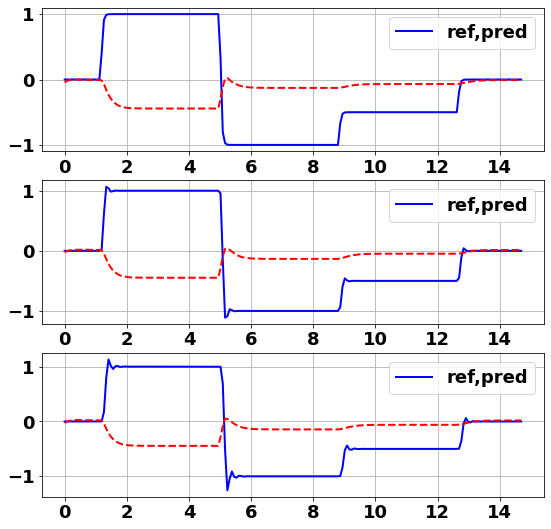

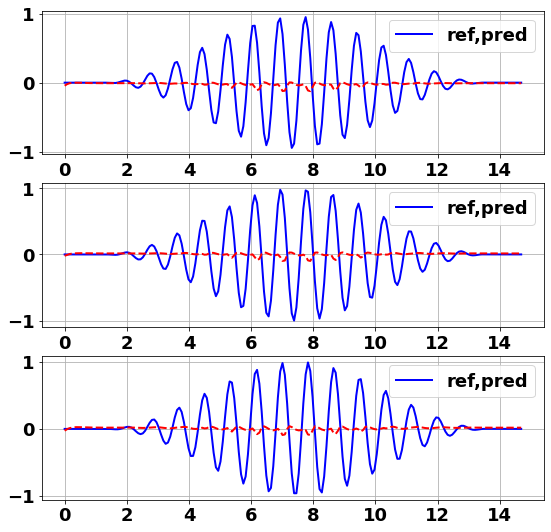

In [91]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[outputs_indexes[k]],'b',t_train,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[outputs_indexes[0]],'b',t_train,y_pred[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])

t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:

    for k in range(No):
        ax[k].plot(t_test,y_test[outputs_indexes[k]],'b',t_test,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[outputs_indexes[0]],'b',t_test,y_test[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


In [92]:
rep = "data/DataSet_ex/"
file_train = "input1.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models/model1"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0,1,2,3,4]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName

Failed to load default container env keys. Using local default keys.
it. 0 / 40 - loss = 0.44054511
it. 1 / 40 - loss = 0.83284664
it. 2 / 40 - loss = 3.56082201
it. 3 / 40 - loss = 3.86312604
it. 4 / 40 - loss = 1.48989046
it. 5 / 40 - loss = 1.60234892
it. 6 / 40 - loss = 2.60061812
it. 7 / 40 - loss = 1.67177260
it. 8 / 40 - loss = 1.10969388
it. 9 / 40 - loss = 0.87761998
it. 10 / 40 - loss = 1.22185910
it. 11 / 40 - loss = 1.32241189
it. 12 / 40 - loss = 1.13927758
it. 13 / 40 - loss = 0.98081964
it. 14 / 40 - loss = 0.78007030
it. 15 / 40 - loss = 0.77750909
it. 16 / 40 - loss = 0.79109722
it. 17 / 40 - loss = 0.77502286
it. 18 / 40 - loss = 0.78821450
it. 19 / 40 - loss = 0.79238778
it. 20 / 40 - loss = 0.76461965
it. 21 / 40 - loss = 0.79016292
it. 22 / 40 - loss = 0.81973344
it. 23 / 40 - loss = 0.84337693
it. 24 / 40 - loss = 0.65172106
it. 25 / 40 - loss = 0.96384317
it. 26 / 40 - loss = 0.78491688
it. 27 / 40 - loss = 0.71085292
it. 28 / 40 - loss = 0.83746231
it. 29 / 40 -

<Figure size 432x288 with 0 Axes>

# 5. Evaluation des solutions <a class="anchor" id="5-bullet"></a>

0. Recuperation des paramètres (modele et entraînement)

In [93]:
with open("./models/model1/hyper.json","r") as f:
    dHyper = json.load(f)

with open("models/model1/model_kwargs.json","r") as f:
    dKwargs = json.load(f)

In [94]:
dHyper,dKwargs

({'model_dir': './models/model1',
  'data_dir': 'data/DataSet_ex/',
  'model_def_file': 'my_model1',
  'epochs': 40,
  'lr': 0.05,
  'outputs_indexes': '1,2,3,4,5',
  'hyper_fileName': 'hyper.json',
  'use_gpu': True,
  'train_fileName': 'input1.csv',
  'Ndecim': 5},
 {'device': 'cpu', 'epochs': 40, 'lr': 0.05, 'output_size': 5})

1. Local metric tests

In [95]:
model1 = MyModel(**dKwargs)

In [99]:
data_dir = "./data/DataSet_ex"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input2.csv'
model_dir       = './models/model1'
model_def_file  = 'my_model2'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


./models/model1\hyper.json
it. 0 / 40 - loss = 0.44376737
it. 1 / 40 - loss = 0.43666089
it. 2 / 40 - loss = 0.43182975
it. 3 / 40 - loss = 0.42657357
it. 4 / 40 - loss = 0.42011803
it. 5 / 40 - loss = 0.41329572
it. 6 / 40 - loss = 0.40612984
it. 7 / 40 - loss = 0.39917415
it. 8 / 40 - loss = 0.39258265
it. 9 / 40 - loss = 0.38671783
it. 10 / 40 - loss = 0.38205230
it. 11 / 40 - loss = 0.37852269
it. 12 / 40 - loss = 0.37602824
it. 13 / 40 - loss = 0.37426940
it. 14 / 40 - loss = 0.37279755
it. 15 / 40 - loss = 0.37159669
it. 16 / 40 - loss = 0.37039253
it. 17 / 40 - loss = 0.36918268
it. 18 / 40 - loss = 0.36833277
it. 19 / 40 - loss = 0.36777604
it. 20 / 40 - loss = 0.36738813
it. 21 / 40 - loss = 0.36722454
it. 22 / 40 - loss = 0.36674294
it. 23 / 40 - loss = 0.36589599
it. 24 / 40 - loss = 0.36526716
it. 25 / 40 - loss = 0.36490086
it. 26 / 40 - loss = 0.36469457
it. 27 / 40 - loss = 0.36438099
it. 28 / 40 - loss = 0.36396378
it. 29 / 40 - loss = 0.36350551
it. 30 / 40 - loss = 0.

In [100]:
with open('./metrics/s2m_GRU2_metrics','r') as f: print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU2
other_remarks : 
team_name : s2m
technology_stack : pytorch
Average inference time [seconds] : 0.0004229972362518311
Entire series inference time [seconds] : 0.42299723625183105
Maximal inference time [seconds] : 0.0020101070404052734
Normalized MSE : [1.67566075 1.45350865 1.30725398 1.26762285 1.2061504 ]
Normalized MSE Sum : 6.910196640034679
Training time [seconds] : 4.842960834503174



2. AWS Metrics tests

In [102]:
metrics_dir = './metrics_sage'
model_def_file = "my_model1"
type_instance = 'ml.m5.xlarge' # Mention that the time limit is t on this specific type of instance

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

2021-10-23 11:05:03 Starting - Starting the training job...
2021-10-23 11:05:27 Starting - Launching requested ML instancesProfilerReport-1634987102: InProgress
......
2021-10-23 11:06:27 Starting - Preparing the instances for training.........
2021-10-23 11:07:48 Downloading - Downloading input data...
2021-10-23 11:08:32 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-23 11:08:33,326 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-23 11:08:33,329 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-23 11:08:33,342 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-23 11:08:36,384 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-23 11:08:36,831 sagemaker-training-toolkit INFO    

In [43]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU1' + '_metrics'),'r') as f:  print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU1
other_remarks : 
team_name : s2m
technology_stack : pytorch
Average inference time [seconds] : 0.0007976224422454834
Entire series inference time [seconds] : 0.7976224422454834
Maximal inference time [seconds] : 0.002095460891723633
Normalized MSE : [1.37938037 3.43960069 1.65857653 2.11001037 2.47360846]
Normalized MSE Sum : 11.061176406956992
Training time [seconds] : 3.8038721084594727



In [37]:
metrics_dir = './metrics_sage'
model_def_file = "my_model2"

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

2021-10-15 09:59:04 Starting - Starting the training job...
2021-10-15 09:59:27 Starting - Launching requested ML instancesProfilerReport-1634291943: InProgress
......
2021-10-15 10:00:30 Starting - Preparing the instances for training............
2021-10-15 10:02:28 Downloading - Downloading input data...
2021-10-15 10:03:08 Training - Downloading the training image...
2021-10-15 10:03:28 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-15 10:03:27,719 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-15 10:03:27,721 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-15 10:03:27,733 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-15 10:03:29,178 sagemaker_pytorch_container.training INFO     Invoking user training 

In [103]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU2' + '_metrics'),'r') as f:  print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU2
other_remarks : 
team_name : s2m
technology_stack : pytorch
Average inference time [seconds] : 0.001013002634048462
Entire series inference time [seconds] : 1.013002634048462
Maximal inference time [seconds] : 0.002193927764892578
Normalized MSE : [1.607422   1.39531446 1.25662091 1.22028149 1.12399065]
Normalized MSE Sum : 6.60362950448196
Training time [seconds] : 5.738161325454712



In [104]:
pwd

'C:\\Users\\CAIRE\\Documents\\Virtual Machines\\shared\\hackathon\\api_sagemaker_final\\AI4IA_phase1_python_win'